In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 50
BATCH_SIZE = 64
PATCH_DIMENSIONS = (128, 128)
DATA_LOCATION = r"D:\data\food"

# Transfer learning 101

In this notebook we will be using the food 101 dataset: https://www.kaggle.com/kmader/food41
We will just load the data in and resize it to 128x128 without looking to much into pre-processing or hyper parameter tuning given it is outside the scope of this session.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(validation_split=0.3, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, zoom_range=0.5)
train_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="training")
validation_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="validation")

Found 70700 images belonging to 101 classes.
Found 30300 images belonging to 101 classes.


## Let's have a look at the data we are dealing with

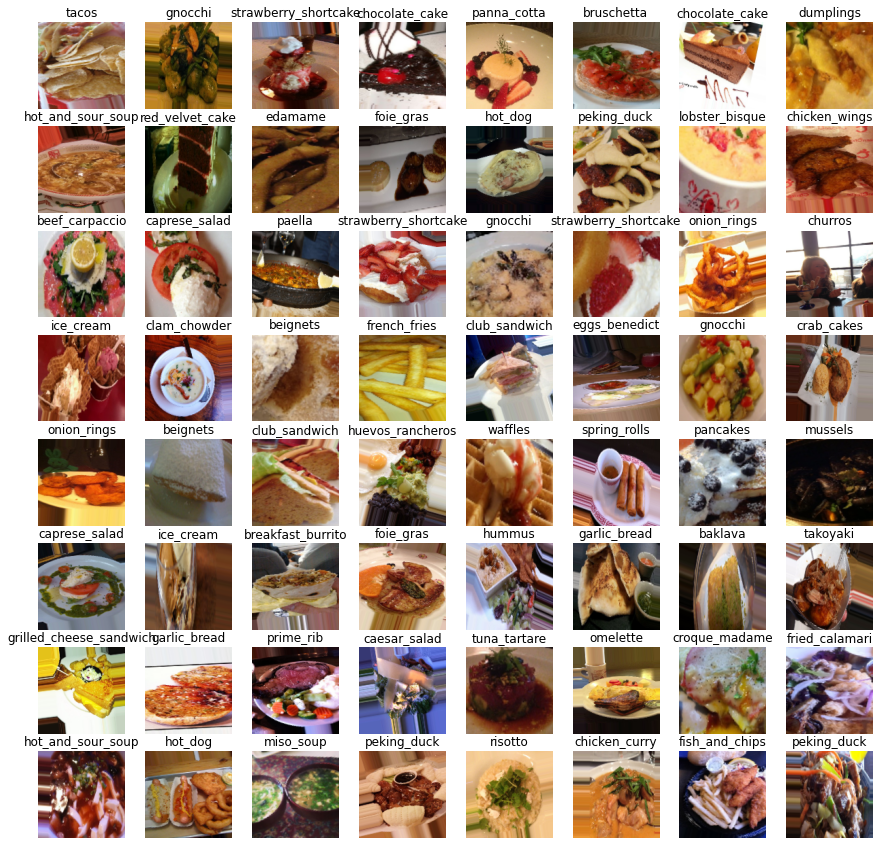

In [5]:
import matplotlib.pyplot as plt
import numpy as np
X, Y = train_generator.__getitem__(0)

classes = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(8, 8,figsize=(15,15))
for x in range(8):
    for y in range(8):
        axes[x][y].imshow((X[x*8 + y]).astype("uint8"))
        class_num = int(np.argmax(Y[x*8 + y]))
        class_name = classes[class_num]
        axes[x][y].title.set_text(class_name)
        axes[x][y].axis('off')

plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have 

In [3]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(weights="imagenet"):
    n_classes = len(classes)
    pre_trained_model = EfficientNetB0(include_top=False, weights=weights)

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model

In [5]:
model_no_pretrain = create_model(None)
history = model_no_pretrain.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
1105/1105 [==============================] - 1442s 1s/step - loss: 4.8591 - accuracy: 0.0123 - val_loss: 5.1814 - val_accuracy: 0.0160
Epoch 2/50
1105/1105 [==============================] - 1288s 1s/step - loss: 4.7971 - accuracy: 0.0156 - val_loss: 4.5871 - val_accuracy: 0.0182
Epoch 3/50
1105/1105 [==============================] - 1050s 951ms/step - loss: 4.7654 - accuracy: 0.0180 - val_loss: 4.8244 - val_accuracy: 0.0199
Epoch 4/50
1105/1105 [==============================] - 669s 605ms/step - loss: 4.7329 - accuracy: 0.0215 - val_loss: 4.6664 - val_accuracy: 0.0245
Epoch 5/50
1105/1105 [==============================] - 920s 833ms/step - loss: 4.5459 - accuracy: 0.0249 - val_loss: 4.4427 - val_accuracy: 0.0361
Epoch 6/50
1105/1105 [==============================] - 828s 749ms/step - loss: 4.3943 - accuracy: 0.0398 - val_loss: 4.3688 - val_accuracy: 0.0442
Epoch 7/50
1105/1105 [==============================] - 694s 628ms/step - loss: 4.3072 - accuracy: 0.0508 - val_los

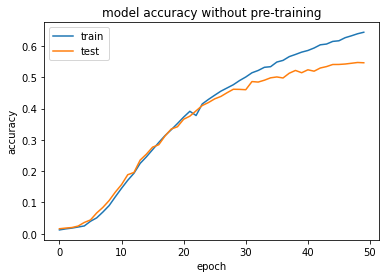

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

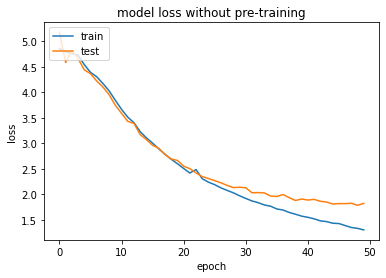

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
model_with_pretrain = create_model("imagenet")
history = model_with_pretrain.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/50
1105/1105 [==============================] - 1750s 2s/step - loss: 2.4991 - accuracy: 0.4059 - val_loss: 1.9701 - val_accuracy: 0.5145
Epoch 2/50
1105/1105 [==============================] - 648s 587ms/step - loss: 1.7349 - accuracy: 0.5557 - val_loss: 1.6534 - val_accuracy: 0.5756
Epoch 3/50
1105/1105 [==============================] - 651s 589ms/step - loss: 1.5475 - accuracy: 0.5969 - val_loss: 1.6266 - val_accuracy: 0.5850
Epoch 4/50
1105/1105 [==============================] - 649s 588ms/step - loss: 1.4249 - accuracy: 0.6266 - val_loss: 1.5553 - val_accuracy: 0.6037
Epoch 5/50
1105/1105 [==============================] - 645s 584ms/step - loss: 1.3319 - accuracy: 0.6468 - val_loss: 1.5284 - val_accuracy: 0.6107
Epoch 6/50
1105/1105 [==============================] - 649s 587ms/step - loss: 1.2592 - accuracy: 0.6646 - val_loss: 1.4454 - val_accuracy: 0.6354
Epoch 7/50
1105/1105 [==============================] - 647s 585ms/step - loss: 1.1917 - accuracy: 0.6801 - val_lo

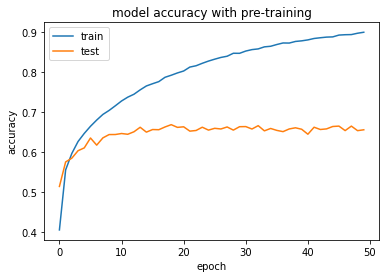

In [7]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

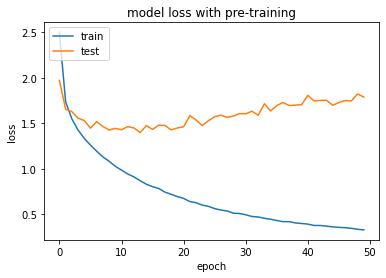

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()